# Question 6

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv("./Data/Quality.csv")
df.rename(columns={"0.051267": "1,0", "0.69956": "0,1", "1.0": "y"}, inplace = True)

In [3]:
for i in range(2, 7):
    for j in range(0, i+1):
        df[f'{i-j},{j}'] = df['1,0'] ** (i-j) * df['0,1'] ** (j)
        
y_column = df.pop('y')
 
df.insert(27, 'y', y_column)
df['y'] = df['y'].map({0.0: 0, 1.0:1})

In [4]:
import numpy as np 
from numpy import log,dot,exp,shape

def standardize(X_tr):
    for i in range(shape(X_tr)[1]):
        X_tr[:,i] = (X_tr[:,i] - np.mean(X_tr[:,i]))/np.std(X_tr[:,i])

class LogisticRegression:
    def sigmoid(self,z):
        sig = 1/(1+np.exp(-z))
        return sig
    
    def initialize(self,X):
        weights = np.zeros((shape(X)[1]+1,1))
        X = np.c_[np.ones((shape(X)[0],1)),X]
        return weights,X
    
    def fit(self,X,y,alpha=0.001,iter=400, lambda_=0.1):
        weights,X = self.initialize(X)
        m = len(y)
        def cost(theta):
            z = dot(X,theta)
            cost0 = y.T.dot(log(self.sigmoid(z)))
            cost1 = (1-y).T.dot(log(1-self.sigmoid(z)))
            reg_term = lambda_/(2 * m) * sum(theta[1:] ** 2)
            cost = -((cost1 + cost0))/m + reg_term 
            return cost
        
        cost_list = np.zeros(iter,)
        for i in range(iter):
            y_prob = self.sigmoid(X @ weights)
            err = y_prob - y.reshape((len(y),1))
            grad = X.T @ err 
            
            weights[0] = weights[0] - alpha*grad[0]
            weights[1:] = weights[1:] - alpha*(grad[1:] + lambda_ * weights[1:])
            cost_list[i] = cost(weights)
        self.weights = weights
        return cost_list
    
    def predict(self,X):
        z = dot(self.initialize(X)[1],self.weights)
        lis = []
        self.prob = []
        for i in self.sigmoid(z):
            self.prob.append(i)
            if i >= 0.5:
                lis.append(1)
            else:
                lis.append(0)
        return lis

In [5]:
from numpy.random import default_rng
import math

n = df.shape[0]
rng = default_rng()
train_size = math.floor(0.8 * n)

numbers = rng.choice(n, size=train_size, replace=False)

train = df.loc[numbers]
X_train = train.iloc[:,0:27]
y_train = np.array(train['y'])


all_index = np.arange(n)
test_index = np.delete(all_index, numbers)
test = df.loc[test_index]
X_test = test.iloc[:,0:27]
y_test = np.array(test['y'])

standardize(X_train.values)
standardize(X_test.values)
obj = LogisticRegression()
model = obj.fit(X_train,y_train, iter=500, lambda_=10)
y_pred = obj.predict(X_test)
y_pred = pd.DataFrame(y_pred)[0]

confusion_mtx =  [[0]*2 for i in range(2)]
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        confusion_mtx[y_pred[i]][y_test[i]] +=1
    else:
        confusion_mtx[y_test[i]][y_pred[i]] +=1
confusion_mtx = np.array(confusion_mtx)     
confusion_mtx

array([[10,  1],
       [ 2, 11]])

In [6]:
# Recall = TruePositives / (TruePositives + FalseNegatives)
# Precision = TruePositives / (TruePositives + FalsePositives)
# Jaccard = tp / (tp + fp + fn)
# f1_score = 2.(Precision * Recall) / (Precision + Recall)
T0=confusion_mtx[0][0]
T1=confusion_mtx[1][1]

F0=confusion_mtx[1][0]
F1=confusion_mtx[0][1]

accuracy = (T0 + T1) / len(y_test)
recall = T1/(T1 + F0)
precision = T1/(T1 + F1)
jaccard = T1/(T1+F1+F0)
f1 = 2*(precision * recall) / (precision + recall)

print(f"accuracy = {accuracy}")
print(f"recall = {recall}")
print(f"precision = {precision}")
print(f"jaccard = {jaccard}")
print(f"f1_score = {f1}")

accuracy = 0.875
recall = 0.8461538461538461
precision = 0.9166666666666666
jaccard = 0.7857142857142857
f1_score = 0.8799999999999999


In [7]:
columns = X_train.columns

w = obj.weights
w = w.reshape(shape(w)[0])

x1 = np.linspace(-0.75, 1.0, 500)
x2 = np.linspace(-0.75, 1.0, 500)
X1, X2 = np.meshgrid(x1,x2)

F = 0
for p, v in zip(columns, w[1:]):
    pw = list(map(int, p.split(',')))
    F += v * (X1 ** pw[0]) * (X2 ** pw[1])

F += w[0]

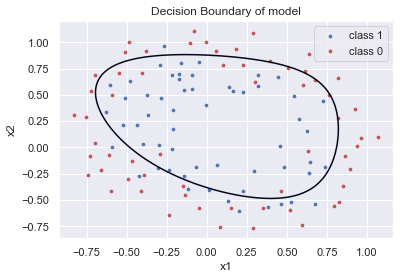

In [22]:
plt.scatter(df[df["y"]==1]['1,0'], df[df["y"]==1]['0,1'], c='b', label='class 1', s = 7)
plt.scatter(df[df["y"]==0]['1,0'], df[df["y"]==0]['0,1'], c='r', label='class 0', s = 7)
plt.contour(X1,X2,F, [-0.5],vmin=0.0, vmax=.6)
# plt.contour(X1,X2,F, 30, cmap="RdBu") #display a colored contour
# plt.colorbar()
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Boundary of model')
plt.show()